In [ ]:
%pip install pybaseball

In [3]:
from pybaseball import (cache, batting_stats_bref, batting_stats, 
                        playerid_reverse_lookup)
import pandas as pd

cache.enable()  # avoid unnecessary requests when re-running

MIN_PLATE_APPEARANCES = 200

# For readability and reasonable default sort order
df_bref = batting_stats_bref(2023).query(f"PA >= {MIN_PLATE_APPEARANCES}"
                                        ).rename(columns={"Lev":"League",
                                                          "Tm":"Team"}
                                                )
df_bref["League"] = \
  df_bref["League"].str.replace("Maj-","").replace("AL,NL","NL/AL"
                                                  ).astype('category')

df_fg = batting_stats(2023, qual=MIN_PLATE_APPEARANCES)

key_mapping = \
  playerid_reverse_lookup(df_bref["mlbID"].to_list(), key_type='mlbam'
                         )[["key_mlbam","key_fangraphs"]
                          ].rename(columns={"key_mlbam":"mlbID",
                                            "key_fangraphs":"IDfg"}
                                  )

df = df_fg.drop(columns="Team"
               ).merge(key_mapping, how="inner", on="IDfg"
                      ).merge(df_bref[["mlbID","League","Team"]],
                              how="inner", on="mlbID"
                             ).sort_values(["League","Team","Name"])

Gathering player lookup table. This may take a moment.


In [12]:
print(df[["OBP","SLG"]].describe().round(3))
print(f"\nCorrelation: \n{df[["OBP", "SLG"]].corr()["OBP"]["SLG"]:.03f}")

           OBP      SLG
count  362.000  362.000
mean     0.320    0.415
std      0.034    0.068
min      0.234    0.227
25%      0.300    0.367
50%      0.318    0.414
75%      0.340    0.460
max      0.416    0.654

Correlation: 
0.630


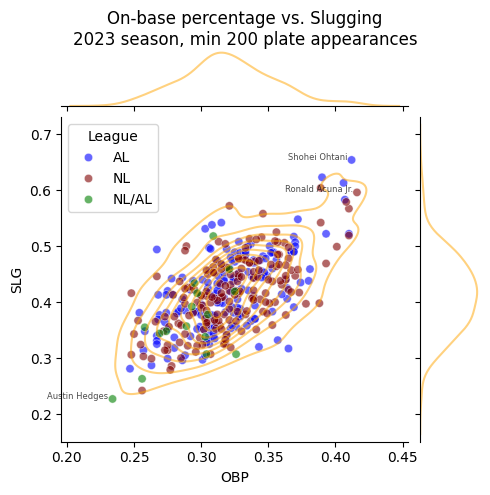

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.JointGrid(data=df, x="OBP", y="SLG", height=5)
g = g.plot_joint(func=sns.scatterplot, data=df, hue="League",
                 palette={"AL":"blue","NL":"maroon","NL/AL":"green"},
                 alpha=0.6
                )
g.fig.suptitle("On-base percentage vs. Slugging\n2023 season, min "
               f"{MIN_PLATE_APPEARANCES} plate appearances"
              )
g.figure.subplots_adjust(top=0.9)
sns.kdeplot(x=df["OBP"], color="orange", ax=g.ax_marg_x, alpha=0.5)
sns.kdeplot(y=df["SLG"], color="orange", ax=g.ax_marg_y, alpha=0.5)
sns.kdeplot(data=df, x="OBP", y="SLG",
            ax=g.ax_joint, color="orange", alpha=0.5
           )
df_extremes = df[ df["OBP"].isin([df["OBP"].min(),df["OBP"].max()]) 
                 | df["OPS"].isin([df["OPS"].min(),df["OPS"].max()])
                ]

for _,row in df_extremes.iterrows():
    g.ax_joint.annotate(row["Name"], (row["OBP"], row["SLG"]),size=6,
                      xycoords='data', xytext=(-3, 0),
                        textcoords='offset points', ha="right",
                      alpha=0.7)
plt.show()

Apply outlier detection algorithms \
Scikit-learn’s outlier detection algorithms typically have fit() and predict() methods, but there are exceptions and also differences between algorithms in their arguments. We’ll consider each algorithm individually, but we’ll fit each to a matrix of attributes (n=2) per player (m=453). We’ll then score not only each player but a grid of values spanning the range of each attribute, to help us visualize the prediction function.

To visualize decision boundaries, we need to take the following steps:

Create a 2D meshgrid of input feature values. \
Apply the decision_function to each point on the meshgrid, which requires unstacking the grid. \
Re-shape the predictions back into a grid. \
Plot the predictions.

In [14]:
import numpy as np

X = df[["OBP","SLG"]].to_numpy()

GRID_RESOLUTION = 200

disp_x_range, disp_y_range = ( (.6*X[:,i].min(), 1.2*X[:,i].max()) 
                               for i in [0,1]
                             )
xx, yy = np.meshgrid(np.linspace(*disp_x_range, GRID_RESOLUTION), 
                     np.linspace(*disp_y_range, GRID_RESOLUTION)
                    )
grid_shape = xx.shape
grid_unstacked = np.c_[xx.ravel(), yy.ravel()]

Elliptic Envelope

The shape of the elliptic envelope is determined by the data’s covariance matrix, which gives the variance of feature i on the main diagonal [i,i] and the covariance of features i and j in the [i,j] positions. Because the covariance matrix is sensitive to outliers, this algorithm uses the Minimum Covariance Determinant (MCD) Estimator, which is recommended for unimodal and symmetric distributions, with shuffling determined by the random_state input for reproducibility. This robust covariance matrix will come in handy again later.

Because we want to compare the outlier scores in their ranking rather than a binary outlier/inlier classification, we use the decision_function to score players.

In [ ]:
%pip install scikit-learn

In [19]:
from sklearn.covariance import EllipticEnvelope

ell = EllipticEnvelope(random_state=17).fit(X)
df["outlier_score_ell"] = ell.decision_function(X)
Z_ell = ell.decision_function(grid_unstacked).reshape(grid_shape)

Local Outlier Factor

This approach to measuring isolation is based on k-nearest neighbors (KNN). We calculate the total distance from each observation to its nearest neighbors to define local density, and then we compare each observation’s local density with that of its neighbors. Observations with local density much less than their neighbors are considered outliers.

Choosing the number of neighbors to include: In KNN, a rule of thumb is to let K = sqrt(N), where N is your observation count. From this rule, we obtain a K close to 20 (which happens to be the default K for LOF). You can increase or decrease K to reduce overfitting or underfitting, respectively.



In [20]:
K = int(np.sqrt(X.shape[0]))

print(f"Using K={K} nearest neighbors.")

Using K=19 nearest neighbors.


Choosing a distance measure: Note that our features are correlated and have different variances, so Euclidean distance is not very meaningful. We will use Mahalanobis distance, which accounts for feature scale and correlation.

In calculating the Mahalanobis distance, we’ll use the robust covariance matrix. If we had not already calculated it via Ellliptic Envelope, we could calculate it directly.

In [21]:
from scipy.spatial.distance import pdist, squareform

# If we didn't have the elliptical envelope already,
# we could calculate robust covariance:
#   from sklearn.covariance import MinCovDet
#   robust_cov = MinCovDet().fit(X).covariance_
# But we can just re-use it from elliptical envelope:
robust_cov = ell.covariance_

print(f"Robust covariance matrix:\n{np.round(robust_cov,5)}\n")

inv_robust_cov = np.linalg.inv(robust_cov)

D_mahal = squareform(pdist(X, 'mahalanobis', VI=inv_robust_cov))

print(f"Mahalanobis distance matrix of size {D_mahal.shape}, "
      f"e.g.:\n{np.round(D_mahal[:5,:5],3)}...\n...\n")

Robust covariance matrix:
[[0.00077 0.00095]
 [0.00095 0.00366]]

Mahalanobis distance matrix of size (362, 362), e.g.:
[[0.    2.86  1.278 0.964 0.331]
 [2.86  0.    2.63  2.245 2.813]
 [1.278 2.63  0.    0.561 0.956]
 [0.964 2.245 0.561 0.    0.723]
 [0.331 2.813 0.956 0.723 0.   ]]...
...



Fitting the Local Outlier Factor: Note that using a custom distance matrix requires us to pass metric="precomputed" to the constructor and then the distance matrix itself to the fit method. (See documentation for more details.)

Also note that unlike other algorithms, with LOF we are instructed not to use the score_samples method for scoring existing observations; this method should only be used for novelty detection.



In [22]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=K, metric="precomputed", novelty=True
                        ).fit(D_mahal)

df["outlier_score_lof"] = lof.negative_outlier_factor_

Create the decision boundary: Because we used a custom distance metric, we must also compute that custom distance between each point in the grid to the original observations. Before we used the spatial measure pdist for pairwise distances between each member of a single set, but now we use cdist to return the distances from each member of the first set of inputs to each member of the second set.

In [24]:
from scipy.spatial.distance import cdist

D_mahal_grid = cdist(XA=grid_unstacked, XB=X, 
                     metric='mahalanobis', VI=inv_robust_cov
                    )
Z_lof = lof.decision_function(D_mahal_grid).reshape(grid_shape)

Support Vector Machine (SGD-One-Class SVM)

SVMs use the kernel trick to transform features into a higher dimensionality where a separating hyperplane can be identified. The radial basis function (RBF) kernel requires the inputs to be standardized, but as the documentation for StandardScaler notes, that scaler is sensitive to outliers, so we'll use RobustScaler. We'll pipe the scaled inputs into Nyström kernel approximation, as suggested by the documentation for SGDOneClassSVM.



In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM

suv = make_pipeline(
            RobustScaler(),
            Nystroem(random_state=17),
            SGDOneClassSVM(random_state=17)
).fit(X)

df["outlier_score_svm"] = suv.decision_function(X)

Z_svm = suv.decision_function(grid_unstacked).reshape(grid_shape)

Isolation Forest

This tree-based approach to measuring isolation performs random recursive partitioning. If the average number of splits required to isolate a given observation is low, that observation is considered a stronger candidate outlier. Like Random Forests and other tree-based models, Isolation Forest does not assume that the features are normally distributed or require them to be scaled. By default, it builds 100 trees. Our example only uses two features, so we do not enable feature sampling.

In [31]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(random_state=17).fit(X)

df["outlier_score_iso"] = iso.score_samples(X)

Z_iso = iso.decision_function(grid_unstacked).reshape(grid_shape)

Results: inspecting decision boundaries

Note that the predictions from these models have different distributions. We apply QuantileTransformer to make them more visually comparable on a given grid. From the documentation, please note:

Note that this transform is non-linear. It may distort linear correlations between variables measured at the same scale but renders variables measured at different scales more directly comparable.



In [ ]:
%pip install adjustText

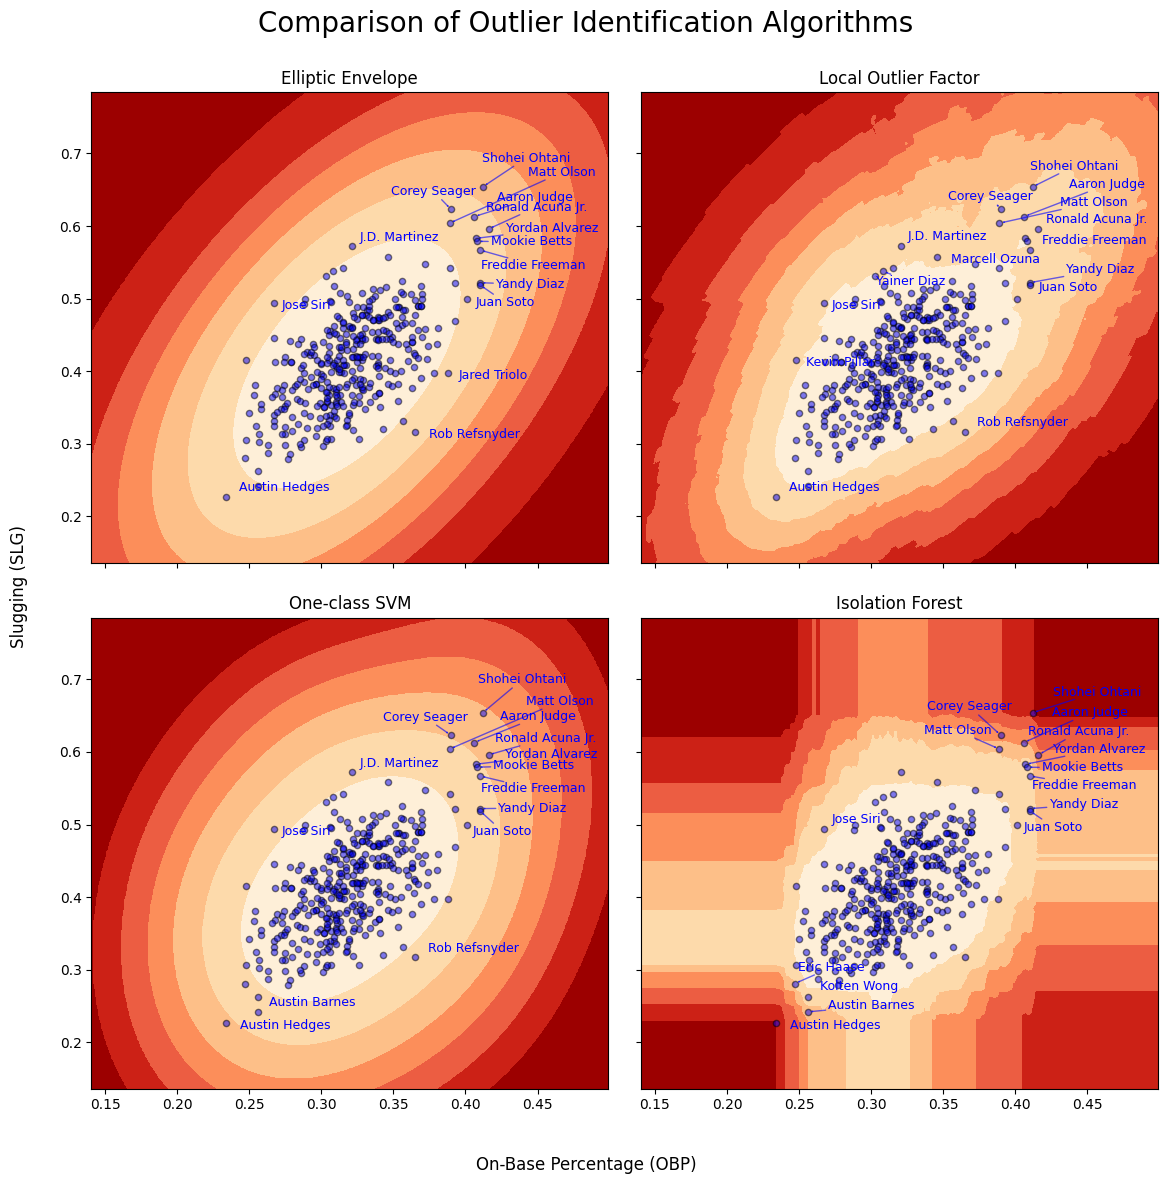

Counting down to the greatest outlier...

            Name  AB  PA   H  2B  3B  HR  BB  HBP  SO   OBP  Pctl_OBP   SLG  Pctl_SLG  Rank_ELL  Rank_ISO  Rank_LOF  Rank_SVM
   Austin Barnes 178 200  32   5   0   2  17    2  43 0.256       2.6 0.242       0.6        19         7        25        12
   J.D. Martinez 432 479 117  27   2  33  34    2 149 0.321      52.8 0.572      98.1        15        18         5        15
      Yandy Diaz 525 600 173  35   0  22  65    8  94 0.410      99.2 0.522      95.4        13        15        13        10
       Jose Siri 338 364  75  13   2  25  20    2 130 0.267       5.5 0.494      88.4         8        14        15        13
       Juan Soto 568 708 156  32   1  35 132    2 129 0.410      99.2 0.519      95.0        12        13        11        11
    Mookie Betts 584 693 179  40   1  39  96    8 107 0.408      98.6 0.579      98.3         7        10        20         7
   Rob Refsnyder 202 243  50   9   1   1  33    5  47 0.365      90.5 0.317 

In [32]:
from adjustText import adjust_text
from sklearn.preprocessing import QuantileTransformer

N_QUANTILES = 8 # This many color breaks per chart
N_CALLOUTS=15  # Label this many top outliers per chart

fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

fig.suptitle("Comparison of Outlier Identification Algorithms",size=20)
fig.supxlabel("On-Base Percentage (OBP)")
fig.supylabel("Slugging (SLG)")

ax_ell = axs[0,0]
ax_lof = axs[0,1]
ax_svm = axs[1,0]
ax_iso = axs[1,1]

model_abbrs = ["ell","iso","lof","svm"]

qt = QuantileTransformer(n_quantiles=N_QUANTILES)

for ax, nm, abbr, zz in zip( [ax_ell,ax_iso,ax_lof,ax_svm], 
                            ["Elliptic Envelope","Isolation Forest",
                             "Local Outlier Factor","One-class SVM"], 
                            model_abbrs,
                            [Z_ell,Z_iso,Z_lof,Z_svm]
                           ):
    ax.title.set_text(nm)
    outlier_score_var_nm = f"outlier_score_{abbr}"
    
    qt.fit(np.sort(zz.reshape(-1,1)))
    zz_qtl = qt.transform(zz.reshape(-1,1)).reshape(zz.shape)

    cs = ax.contourf(xx, yy, zz_qtl, cmap=plt.cm.OrRd.reversed(), 
                     levels=np.linspace(0,1,N_QUANTILES)
                    )
    ax.scatter(X[:, 0], X[:, 1], s=20, c="b", edgecolor="k", alpha=0.5)
    
    df_callouts = df.sort_values(outlier_score_var_nm).head(N_CALLOUTS)
    texts = [ ax.text(row["OBP"], row["SLG"], row["Name"], c="b",
                      size=9, alpha=1.0) 
             for _,row in df_callouts.iterrows()
            ]
    adjust_text(texts, 
                df_callouts["OBP"].values, df_callouts["SLG"].values, 
                arrowprops=dict(arrowstyle='->', color="b", alpha=0.6), 
                ax=ax
               )

plt.tight_layout(pad=2)
plt.show()

for var in ["OBP","SLG"]:
    df[f"Pctl_{var}"] = 100*(df[var].rank()/df[var].size).round(3)

model_score_vars = [f"outlier_score_{nm}" for nm in model_abbrs]  
model_rank_vars = [f"Rank_{nm.upper()}" for nm in model_abbrs]


df[model_rank_vars] = df[model_score_vars].rank(axis=0).astype(int)
    
# Averaging the ranks is arbitrary; we just need a countdown order
df["Rank_avg"] = df[model_rank_vars].mean(axis=1)

print("Counting down to the greatest outlier...\n")
print(
    df.sort_values("Rank_avg",ascending=False
                  ).tail(N_CALLOUTS)[["Name","AB","PA","H","2B","3B",
                                      "HR","BB","HBP","SO","OBP",
                                      "Pctl_OBP","SLG","Pctl_SLG"
                                     ] + 
                             [f"Rank_{nm.upper()}" for nm in model_abbrs]
                            ].to_string(index=False)
)